In [1]:
#Import des csv

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import warnings

# Traitement des données

In [2]:
warnings.filterwarnings("ignore")

crypto_prices = pd.read_csv("crypto_prices_v2.csv")
# Convert timestamp column to datetime format
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])

# Set timestamp column as index
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices.head()

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,bid-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,0.013622,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,0.013083,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,0.014231,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,0.013833,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,0.012865,705.739433,0.608839,1.199186


In [3]:
exchange_info = pd.read_csv("exchange_info_v2.csv")

In [4]:
crix = pd.read_csv("crix.csv", delimiter=";")
crix['date'] = pd.to_datetime(crix['date'])

In [5]:
data_factors = pd.read_csv("data_factors.csv", delimiter=";", header=4)
data_factors = data_factors.rename(columns={data_factors.columns[0]: 'timestamp'})
data_factors = data_factors.iloc[:-1]
# Convert timestamp column to datetime format
data_factors['timestamp'] = pd.to_datetime(data_factors['timestamp'])


In [6]:
momentum_daily = pd.read_csv("momentum_daily.csv", delimiter=";", header=13)
momentum_daily.fillna(0, inplace=True)
momentum_daily = momentum_daily.iloc[:, :-2]

# Convert date column to timestamp format
momentum_daily = momentum_daily.rename(columns={momentum_daily.columns[0]: 'timestamp'})
momentum_daily = momentum_daily.iloc[:-2]
momentum_daily['timestamp'] = pd.to_datetime(momentum_daily['timestamp'])

# Implémentation des différents algorithmes


### I) GetPortfolioCompo

In [7]:

rebalancing_dates = pd.date_range(start=crypto_prices.index.min(), end=crypto_prices.index.max(), freq='MS')
rebalancing_dates = rebalancing_dates[1:]
def get_portfolio_compo(df, rebalancing_dates, portfolio_index, horizon):
    portfolio_data = []
    
    for date in rebalancing_dates:
        portfolios = {}
        for i in range(portfolio_index):
            # Sélectionner les données de marché pour la date de rééquilibrage
            market_data = df.loc[date]
            
            # Calculer les rendements sur l'horizon spécifié
            returns = (market_data - df.shift(periods=horizon).loc[date]) / df.shift(periods=horizon).loc[date]
            
            # Classer les cryptomonnaies en fonction des rendements décroissants
            ranked_cryptos = returns.sort_values(ascending=False)
            
            # Extraire les noms des cryptomonnaies pour le portefeuille i+1
            portfolio = ranked_cryptos.iloc[i * 10: (i + 1) * 10]
            
            # Ajouter les noms et les rendements des cryptomonnaies au portefeuille
            portfolio_with_returns = [crypto_name for crypto_name, return_value in portfolio.items()]
            portfolios[f"Portfolio_{i+1}"] = portfolio_with_returns
            
        portfolio_data.append(portfolios)
    
    # Créer un DataFrame à partir des données de portefeuille
    portfolio_df = pd.DataFrame(portfolio_data, index=rebalancing_dates)
    
    return portfolio_df

# Supposons que vous voulez le portefeuille P1 à chaque date de rééquilibrage avec un horizon de 1 jour
portfolios_df = get_portfolio_compo(crypto_prices, rebalancing_dates, portfolio_index=9, horizon=15)


### II) ComputePortfolioValues, UpdateCmpo et UpdateValue

In [8]:
def UpdateValue(date, crypto_prices, portfolio_compo, initial_value):
    if len(portfolio_compo) == 0:
        return initial_value
    portfolio_value = (crypto_prices.loc[date, list(portfolio_compo.keys())] * list(portfolio_compo.values())).sum()
    return portfolio_value


def UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices):
    portfolio_compo.clear()
    portefeuille_actuelle = portfolios_df.loc[date, f"Portfolio_{portfolio_index}"]
    portfolio_compo.update({crypto_name: portfolio_value / (10 * crypto_prices.loc[date, crypto_name]) for crypto_name in portefeuille_actuelle})


def compute_portfolio_values(crypto_prices,portfolios_df, rebalancing_dates, portfolio_index, horizon, initial_value):
    portfolio_compo = {}
    portfolio_values = [initial_value]
    portfolio_value = initial_value

    for date in crypto_prices.index:
        portfolio_value = UpdateValue(date, crypto_prices, portfolio_compo, initial_value)
        if date in rebalancing_dates:
            UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices)
        portfolio_values.append(portfolio_value)

    return portfolio_values





# Etude des portefeuilles 1 à 9

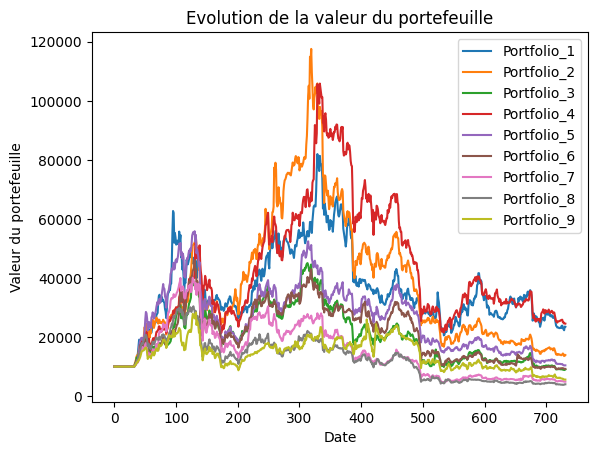

In [9]:


# Initialiser la valeur initiale du portefeuille
initial_portfolio_value = 10000  # Par exemple, 10000 USD

# Indices de portefeuille à considérer
portfolio_indices = range(1, 10)

# Calculer les valeurs des portefeuilles pour les dates de rééquilibrage
portfolio_values_dict = {}


for portfolio_index in portfolio_indices:
    portfolio_values = compute_portfolio_values(crypto_prices,portfolios_df, rebalancing_dates, portfolio_index, horizon=15, initial_value=initial_portfolio_value)
    portfolio_values_dict[f"Portfolio_{portfolio_index}"] = portfolio_values
portfolio_values_df = pd.DataFrame(portfolio_values_dict)

# Afficher les graphiques pour chaque indice de portefeuille
for portfolio_index, portfolio_values in portfolio_values_dict.items():
    plt.plot(portfolio_values, label=portfolio_index)

plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.show()

### Daily returns

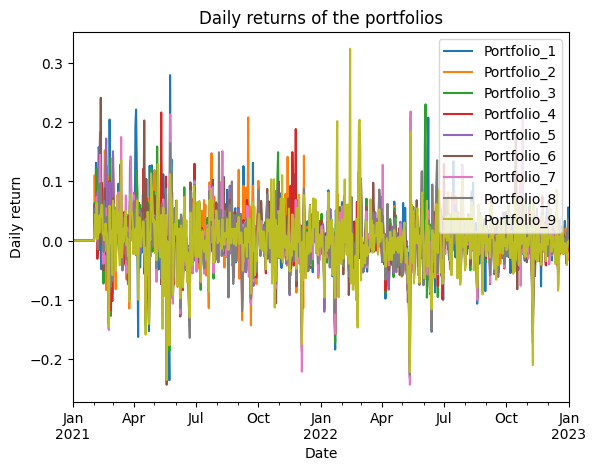

In [10]:
#on drop les nan
portfolio_values_df = portfolio_values_df.dropna()
#on drop la premiere ligne de portfolio_values_df
portfolio_values_df = portfolio_values_df.iloc[1:]
#on rajoute les timestamp de crypto_prices comme index de portfolio_values_df
portfolio_values_df.index = crypto_prices.index


portfolio_daily_returns = portfolio_values_df.pct_change()
portfolio_daily_returns.plot(title='Daily returns of the portfolios', xlabel='Date', ylabel='Daily return')
plt.show()



### Creation de dataframe contenant RF pour chaque timestamp de cryptoprices afin de faciliter les calculs de ratio de sharpe.

In [11]:
first_date = data_factors['timestamp'].min()
last_date = crypto_prices.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_df = portfolio_daily_returns.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_df = merged_df.loc[rebalancing_dates[0]:]
merged_df = merged_df.iloc[1:]


### Statistiques sur les daily returns

In [12]:
# Compute the indicators for each returns series
indicators = {}

for column in merged_df.columns:
    returns = merged_df[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Print the indicators for each returns series
for column, values in indicators.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()

Indicators for Portfolio_1:
Mean: 0.0024189755428441623
Stddev: 0.04909171023676607
Median: 0.00044979488285279423
Min: -0.2354454012165209
Max: 0.27904042829100795
Skewness: 0.35327548213087545
Kurtosis: 4.534457832069984

Indicators for Portfolio_2:
Mean: 0.0015421065537396539
Stddev: 0.04610495381703023
Median: 0.002020784381006502
Min: -0.23399131987880273
Max: 0.2079784041952406
Skewness: -0.16798598793805183
Kurtosis: 2.663403491830193

Indicators for Portfolio_3:
Mean: 0.0008975287440794944
Stddev: 0.04537432510338965
Median: 0.0013356182989860965
Min: -0.20423867559770226
Max: 0.22977989445527802
Skewness: -0.27138779999522405
Kurtosis: 3.439491807244904

Indicators for Portfolio_4:
Mean: 0.0022482924202351863
Stddev: 0.043802916095904185
Median: 0.0027760074353029296
Min: -0.173569784239326
Max: 0.21609208940337776
Skewness: -0.06198672151397107
Kurtosis: 2.7934979474108896

Indicators for Portfolio_5:
Mean: 0.0009571849867231523
Stddev: 0.04212976575367125
Median: 0.002613988

In [13]:
#on soustrait RF à chaque daily return
merged_df['Portfolio_1'] = merged_df['Portfolio_1'] - merged_df['RF']
merged_df['Portfolio_2'] = merged_df['Portfolio_2'] - merged_df['RF']
merged_df['Portfolio_3'] = merged_df['Portfolio_3'] - merged_df['RF']
merged_df['Portfolio_4'] = merged_df['Portfolio_4'] - merged_df['RF']
merged_df['Portfolio_5'] = merged_df['Portfolio_5'] - merged_df['RF']
merged_df['Portfolio_6'] = merged_df['Portfolio_6'] - merged_df['RF']
merged_df['Portfolio_7'] = merged_df['Portfolio_7'] - merged_df['RF']
merged_df['Portfolio_8'] = merged_df['Portfolio_8'] - merged_df['RF']
merged_df['Portfolio_9'] = merged_df['Portfolio_9'] - merged_df['RF']


### Ratio de Sharpe

In [14]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
sharpe_ratios_portfolios = (merged_df.mean()) / merged_df.std()
print("Le ratio de sharpe des portefeuilles 1 à 9 :","\n",sharpe_ratios_portfolios[0:9])

Le ratio de sharpe des portefeuilles 1 à 9 : 
 Portfolio_1    0.048671
Portfolio_2    0.032806
Portfolio_3    0.019130
Portfolio_4    0.050651
Portfolio_5    0.022018
Portfolio_6    0.018929
Portfolio_7    0.001003
Portfolio_8   -0.007895
Portfolio_9    0.008511
dtype: float64


### Calcul des ratio des Treynor / alpha de Jensen.

In [15]:

mkt_RF_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df['Mkt-RF'] = mkt_RF_df['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_mkt_RF_df = merged_df.merge(mkt_RF_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df = merged_mkt_RF_df.loc[rebalancing_dates[0]:]
merged_mkt_RF_df = merged_mkt_RF_df.iloc[1:]

merged_mkt_RF_df.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF
timestamp,,,,,,,,,,,
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058
2021-02-07,0.078834,0.002044,0.001293,-0.009741,-0.009109,-0.000523,0.006110,-0.014703,0.021444,0.0,0.0058


### Regression pour obtenir les betas et alphas de Jensen

In [16]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 10):
    # Select the portfolio values and the Mkt-RF column
    X = merged_mkt_RF_df['Mkt-RF']
    y = merged_mkt_RF_df[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha = results.params[0]
    beta = results.params[1]
    
    # Print the alpha and beta coefficients
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha}')
    print(f'Beta (Market): {beta}')
    print()

Portfolio_1:
Alpha (Jensen): 0.002211051965643519
Beta (Market): 0.9668945659725882

Portfolio_2:
Alpha (Jensen): 0.0012218331155011012
Beta (Market): 0.8631491632186671

Portfolio_3:
Alpha (Jensen): 0.0006644494806484474
Beta (Market): 0.7247641113387633

Portfolio_4:
Alpha (Jensen): 0.002057938243443774
Beta (Market): 0.72863776374779

Portfolio_5:
Alpha (Jensen): 0.0007752319798164464
Beta (Market): 0.6985207364816501

Portfolio_6:
Alpha (Jensen): 0.0006241096234047731
Beta (Market): 0.7716782988465907

Portfolio_7:
Alpha (Jensen): -0.00013394788592596563
Beta (Market): 0.9298103120554839

Portfolio_8:
Alpha (Jensen): -0.0005540491522037425
Beta (Market): 0.8879396501442148

Portfolio_9:
Alpha (Jensen): 0.00024568374310872566
Beta (Market): 1.0151355577082932



### Ratio de Treynor

In [17]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
treynor_ratios_portfolios = (merged_df.mean()) / beta
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_portfolios[0:9])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 Portfolio_1    0.002354
Portfolio_2    0.001490
Portfolio_3    0.000855
Portfolio_4    0.002186
Portfolio_5    0.000914
Portfolio_6    0.000819
Portfolio_7    0.000046
Portfolio_8   -0.000342
Portfolio_9    0.000424
dtype: float64


### Simulation de FAMA & FRENCH

In [18]:
fm_portfolios = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolios['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolios['Mkt-RF'] = fm_portfolios['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolios['HML'].fillna(method='ffill', inplace=True)
fm_portfolios['HML'] = fm_portfolios['HML'].str.replace(',', '.').astype(float)/100
fm_portfolios['SMB'].fillna(method='ffill', inplace=True)
fm_portfolios['SMB'] = fm_portfolios['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolios = merged_df.merge(fm_portfolios, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolios = fm_portfolios.loc[rebalancing_dates[0]:]
X=fm_portfolios[['HML', 'SMB','Mkt-RF']]


In [19]:
import pandas as pd

# Création d'un DataFrame vide pour les cryptomonnaies centralisées
centralized_df = pd.DataFrame()

# Liste des noms de cryptomonnaies centralisées
centralized_crypto_names = exchange_info[exchange_info['CeX'] == True]['Unnamed: 0'].values

# Parcourir les colonnes du DataFrame crypto_prices
for crypto in crypto_prices.columns:
    # Vérifier si la cryptomonnaie est centralisée
    if crypto in centralized_crypto_names:
        # Ajouter la cryptomonnaie au DataFrame centralized_df
        centralized_df[crypto] = crypto_prices[crypto]

# on fait pareil pour les cryptomonnaies décentralisées
decentralized_df = pd.DataFrame()
decentralized_crypto_names = exchange_info[exchange_info['DeX'] == False]['Unnamed: 0'].values
for crypto in crypto_prices.columns:
    if crypto in decentralized_crypto_names:
        decentralized_df[crypto] = crypto_prices[crypto]
centralized_df.head()
    

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,gala-usdt,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,0.001185,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,0.001151,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,0.001182,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,0.001310,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,0.001525,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,705.739433,0.608839,1.199186


# Etude des crypto centralisées

In [20]:
portfolio_1_8_centralized = get_portfolio_compo(centralized_df, rebalancing_dates, portfolio_index=8, horizon=15)

premier_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=1, horizon=15, initial_value=initial_portfolio_value)
deuxieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=2, horizon=15, initial_value=initial_portfolio_value)
troisieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=3, horizon=15, initial_value=initial_portfolio_value)
quatrieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=4, horizon=15, initial_value=initial_portfolio_value)
cinquieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=5, horizon=15, initial_value=initial_portfolio_value)
sixieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=6, horizon=15, initial_value=initial_portfolio_value)
septieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=7, horizon=15, initial_value=initial_portfolio_value)
huitieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=8, horizon=15, initial_value=initial_portfolio_value)





{'Portfolio_1': [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10211.513669114916, 10830.263511674979, 12252.888700374902, 12580.689363964815, 13444.724709837043, 14504.629080356373, 16792.23795845539, 19122.633833218537, 18818.048570438514, 18843.624037024736, 17932.963382185942, 18502.56194032761, 18802.278114500383, 19211.16900414085, 19348.38137464317, 19301.545947856084, 19883.75653107679, 19177.32939693024, 20502.265163049586, 20131.49474117407, 19019.45781402707, 16934.367406853584, 20390.955369591833, 21762.761444354528, 21714.597621717847, 22748.390127414055, 21359.454987299276, 21485.76552489857, 22951.02079948164, 24000.42592252603, 24573.704172801696, 23997.60419447464, 24622.115787546114, 24717.756782581928, 25007.529568855687, 27408.994421559397, 27803.05693113099, 28189.711277920534, 31799